### **线性回归的实现**

In [1]:
%matplotlib inline 
import random
import torch
from d2l import torch as d2l  

根据带有噪声的线性模型构造一个**人造数据集**。我们使用线性模型参数$w=[2,-3.4]^T、b=4.2$和噪声项$\epsilon$生成数据集及其标签：  
$
\pmb{y}=\pmb{Xw}+b+\epsilon
$

> 构造真实数据集的好处是我们可以知道真实的$w$和$b$

##### **构造训练样本**

In [6]:
def synthetic_data(w, b, num_examples):
    '''生成 y = XW + b + 噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))  #X是一个均值为0、方差为1的随机数，他的大小是有n个样本，列数是w的长度
    y = torch.matmul(X, w) +b                       #y是X乘w再加上偏差b
    y += torch.normal(0, 0.01, y.shape)             #加入随机噪声：均值为0、方差为0.01，形状和y一样
    return X, y.reshape((-1,1))                     #将X、变成列向量的y返回

true_w = torch.tensor([2, -3.4])                    #定义真实的w和真实的b
true_b = 4.2  
features, labels = synthetic_data(true_w, true_b, 1000)  #就可以利用synthetic_data函数来生成特征(features)和标注(labels)

In [7]:
print('features:', features[0], '\nlabel:', labels[0])  #第0个样本(是一个长为2的tensor)，样本的标号就是一个标量

features: tensor([1.3111, 1.0247]) 
label: tensor([3.3424])


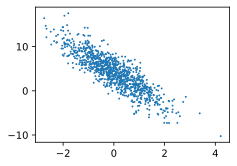

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);  #把特征函数的第一列和labels(标号)detach出来，转到numpy里面

##### **读取数据集**

练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量，每个小批量包含一组特征和标签。

In [11]:
def data_iter(batch_size, features, labels):            #定义函数接收批量大小(batch_size)、特征矩阵(features)和标签向量(labels)作为输入
    num_examples = len(features)            #给一个样本
    indices = list(range(num_examples))         #生成每一个样本的indices，range表示从0到n-1，转化为python中的list
    # 这些样本是随机读取的，没有特定顺序  
    random.shuffle(indices)             #随机打乱这些下标
    for i in range(0, num_examples, batch_size):            #对于每一次从0开始到num_examples跳batch_size个大小
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])      #把batch的indices找出来从i开始到i + batch_size个，如果最后一个没有取满便取到最小
        yield features[batch_indices], labels[batch_indices]        #yield表示构造了一个生成器，每次返回一个features和一个labels，不断调用并返回，直到调用完成为止

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [12]:
batch_size = 10         #这里给定batch_size = 10 

for X, y in data_iter(batch_size, features, labels):        #调用函数返回iter，每次从中拿到一个X和一个y
    print(X, '\n', y)       #X为一个10×2的tensor；y为一个10×1的向量  
    break  


tensor([[ 0.4288, -0.4908],
        [-0.3325,  0.3091],
        [-2.2295, -0.3373],
        [-0.1234,  0.0905],
        [-0.4083,  0.4158],
        [-0.6141, -1.3194],
        [-0.0510,  0.8565],
        [-0.7496,  1.3005],
        [ 0.3265,  0.3641],
        [-0.4605, -0.2201]]) 
 tensor([[ 6.7094],
        [ 2.4791],
        [ 0.9010],
        [ 3.6457],
        [ 1.9611],
        [ 7.4652],
        [ 1.1765],
        [-1.7069],
        [ 3.6102],
        [ 4.0313]])


##### **定义 初始化模型参数**

In [13]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)          #将w随机初始化为均值为0、方差为0.01、长为2的正态分布向量，要进行更新，所以=True
b = torch.zeros(1, requires_grad=True)          #对偏差初始为0(标量，对偏差要进行更新，所以=True)

##### **定义模型**

In [14]:
def linreg(X, w, b):        #给定输入X(批量大小的样本)，给定w和b
    """线性回归模型"""
    return torch.matmul(X, w) + b       #返回预测 输入X(矩阵) × w(向量) + 偏差

##### **定义损失函数**

In [15]:
def squared_loss(y_hat, y):         #定义平方损失函数，其中y_hat为预测值，y为真实值
    """均方损失"""  
    return (y_hat - y.reshape(y_hat.shape))**2 / 2          #使形状一样(把y.reshape成y_hat的形状)按元素做减法再平方之后除以2

##### **定义优化算法**

In [16]:
def sgd(params, lr, batch_size):        #定义优化算法sgd(给定所有参数|包含了w和b|，学习率，batch_size)
    """小批量随机梯度下降"""
    with torch.no_grad():       #更新参数时不需要参与梯度计算
        for param in params:        #对于params中的每一个参数|w和b|
            param -= lr * param.grad / batch_size       #对于 param - 学习率 * 对应的梯度 / batch_size
            param.grad.zero_()          #梯度归0

##### **训练过程**

In [17]:
lr = 0.03       # 学习率
num_epochs = 3          # 把数据历三遍
net = linreg        # 之前定义的模型
loss = squared_loss         # 均方损失

for epoch in range(num_epochs):         # 对每层数据扫一遍
    for X, y in data_iter(batch_size, features, labels):        # 每次拿出批量大小的一个X，y
        l = loss(net(X, w, b), y)       # 把X，w，b拿来做预测，把预测的y和真实的y做损失；损失就是一个长为批量大小的向量
        # 因为'l'形状时('batch_size', l)，而不是一个标量。'l'中所有元素被加到一起
        # 并以此计算关于['w', 'b']的梯度
        l.sum().backward()          # 做求和，求和之后计算梯度
        sgd([w, b], lr, batch_size)     #使用sgd进行参数的梯度更新参数
    with torch.no_grad():       
        train_l = loss(net(features, w, b), labels)         # 把所有数据传进去，和真实值做一次损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036232
epoch 2, loss 0.000134
epoch 3, loss 0.000054


In [23]:
print(f'w的误差为:{true_w - w.reshape(true_w.shape)}')
print(f'b的误差为:{true_b - b}')

w的误差为:tensor([ 0.0003, -0.0008], grad_fn=<SubBackward0>)
b的误差为:tensor([0.0005], grad_fn=<RsubBackward1>)
